# Dogs vs. Cats

In [1]:
# /.keras/models

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [2]:
import numpy as np
import keras
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array

Using TensorFlow backend.


In [3]:
from keras.applications.densenet import DenseNet201, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [4]:
IMG_SIZE = (299, 299)  # размер входного изображения сети

## Функции загрузки данных

In [5]:
import re
from random import shuffle
from glob import glob

train_files = glob('./train/*.jpg')
test_files = glob('./test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = load_img(path, target_size=target_size)  # загрузка и масштабирование изображения
    array = img_to_array(img)
    return preprocess_input(array)  # предобработка для VGG16

# генератор для последовательного чтения обучающих данных с диска
def fit_generator(files, batch_size=32):
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if re.match('.*/dog\.\d', path) else 0. for path in files[i:j]])
            yield (x, y)

# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

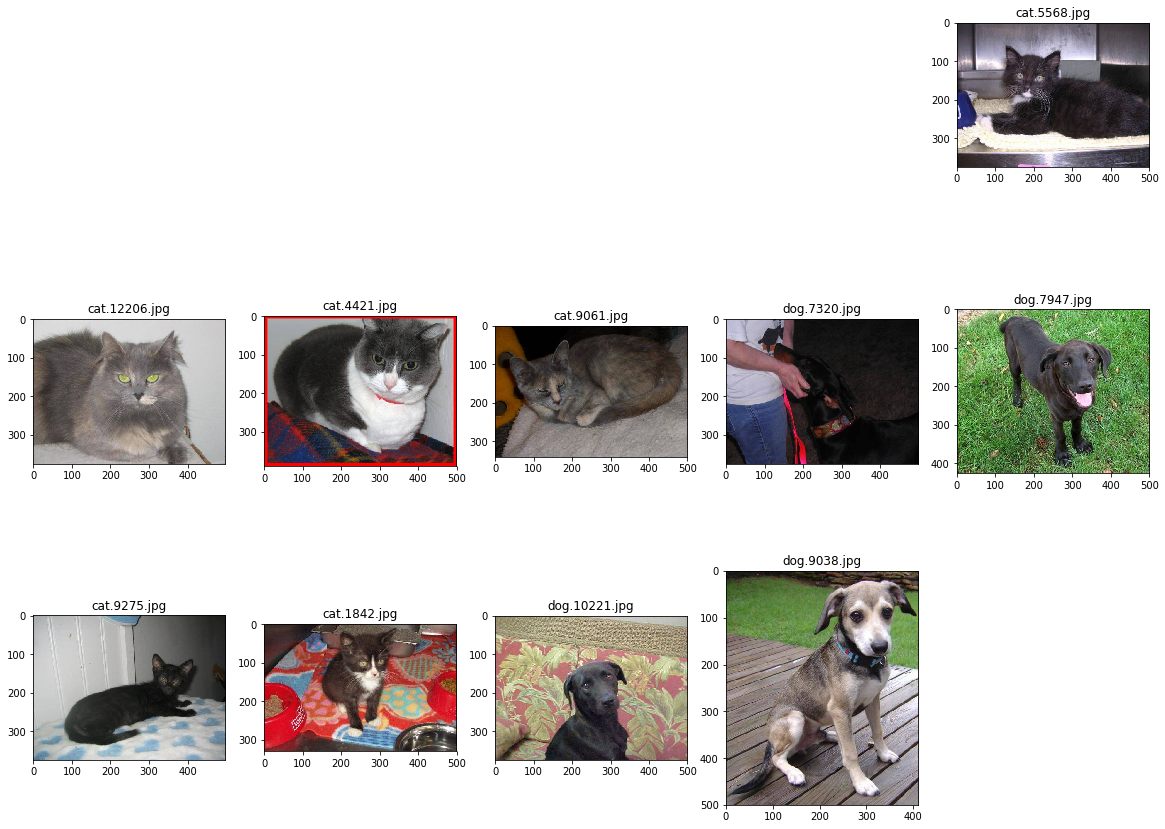

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%s' % path.split('/')[-1]);

## Загружаем предобученную модель

In [7]:
base_model = VGG16(include_top=False,
                         weights='imagenet',
                         input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3)
                        )

In [8]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

In [9]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 74, 74, 128)       0         
__________

## Добавляем полносвязный слой

In [10]:
x = base_model.layers[-1].output
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation='relu',
                      kernel_regularizer=keras.regularizers.l2(1e-4))(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1,  # один выход
                activation='sigmoid',  # функция активации  
                kernel_regularizer=keras.regularizers.l2(1e-4))(x)
model = Model(inputs=base_model.input, outputs=x)

## Выводим архитектуру модели

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 74, 74, 128)       0         
__________

## Компилируем модель и запускаем обучение

In [12]:
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss)
              metrics=['accuracy'])

In [13]:
shuffle(train_files)  # перемешиваем обучающую выборку

train_val_split = 2500  # число изображений в валидационной выборке
train_len = 25000 - 2500

validation_data = next(fit_generator(train_files[:train_val_split], train_val_split))   # run the generator at once

filepath="cats-dogs-weights-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='min', baseline=None)
callbacks_list = [earlystop, checkpoint]

# запускаем процесс обучения
batch_size = 128
model.fit_generator(
    fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
    steps_per_epoch=train_len//batch_size,  # число вызовов генератора за эпоху
    epochs=50,                              # число эпох обучения
    validation_data=validation_data,
    callbacks=callbacks_list    
)

Epoch 1/50
175/175 [==============================] - 54s 310ms/step - loss: 7.9783 - acc: 0.5002 - val_loss: 8.0121 - val_acc: 0.4976

Epoch 00001: val_loss improved from inf to 8.01213, saving model to cats-dogs-weights-01-8.0121.hdf5
Epoch 2/50
175/175 [==============================] - 51s 294ms/step - loss: 2.0331 - acc: 0.8102 - val_loss: 0.2424 - val_acc: 0.9100

Epoch 00002: val_loss improved from 8.01213 to 0.24239, saving model to cats-dogs-weights-02-0.2424.hdf5
Epoch 3/50
175/175 [==============================] - 51s 294ms/step - loss: 0.2248 - acc: 0.9291 - val_loss: 0.0867 - val_acc: 0.9764

Epoch 00003: val_loss improved from 0.24239 to 0.08668, saving model to cats-dogs-weights-03-0.0867.hdf5
Epoch 4/50
175/175 [==============================] - 51s 292ms/step - loss: 0.1709 - acc: 0.9462 - val_loss: 0.0899 - val_acc: 0.9764

Epoch 00004: val_loss did not improve from 0.08668
Epoch 5/50
175/175 [==============================] - 51s 291ms/step - loss: 0.1458 - acc: 0.9

In [14]:
# stop_epoch = 3

In [15]:
# # Run on the whole train data
# model.compile(optimizer='rmsprop', 
#               loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss)
#               metrics=['accuracy'])

# shuffle(train_files)  # перемешиваем обучающую выборку
# train_len = 25000
# # filepath="cats-dogs-weights-{epoch:02d}-{loss:.4f}.hdf5"
# # checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
# # earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='min', baseline=None)
# # callbacks_list = [checkpoint]

# # запускаем процесс обучения
# batch_size = 128
# model.fit_generator(
#     fit_generator(train_files),             # данные читаем функцией-генератором
#     steps_per_epoch=train_len//batch_size,  # число вызовов генератора за эпоху
#     epochs=stop_epoch                       # число эпох обучения
# #     callbacks=callbacks_list
# )

In [16]:
# model.save('cats-dogs-weights-epoch3.hdf5')

## Предсказания на проверочной выборке

In [20]:
model.load_weights("cats-dogs-weights-03-0.0867.hdf5")

In [21]:
pred = model.predict_generator(predict_generator(test_files), len(test_files), max_queue_size=500)

In [ ]:
# %matplotlib inline
# from matplotlib import pyplot as plt
# fig = plt.figure(figsize=(20, 20))
# for i, (path, score) in enumerate(zip(test_files[80:][:10], pred[80:][:10]), 1):
#     subplot = fig.add_subplot(i // 5 + 1, 5, i)
#     plt.imshow(plt.imread(path));
#     subplot.set_title('%.3f' % score);

## Готовим данные для сабмита

In [22]:
with open('submit.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, pred):
        dst.write('%s,%f\n' % (re.search('(\d+)', path).group(0), score))

In [23]:
!head submit.txt

id,label
4293,0.000714
10861,0.999920
9580,0.000012
9065,0.010837
7863,0.000002
4860,0.999999
4962,1.000000
11464,0.993668
7584,0.999789


Public score


logloss = 0.16884

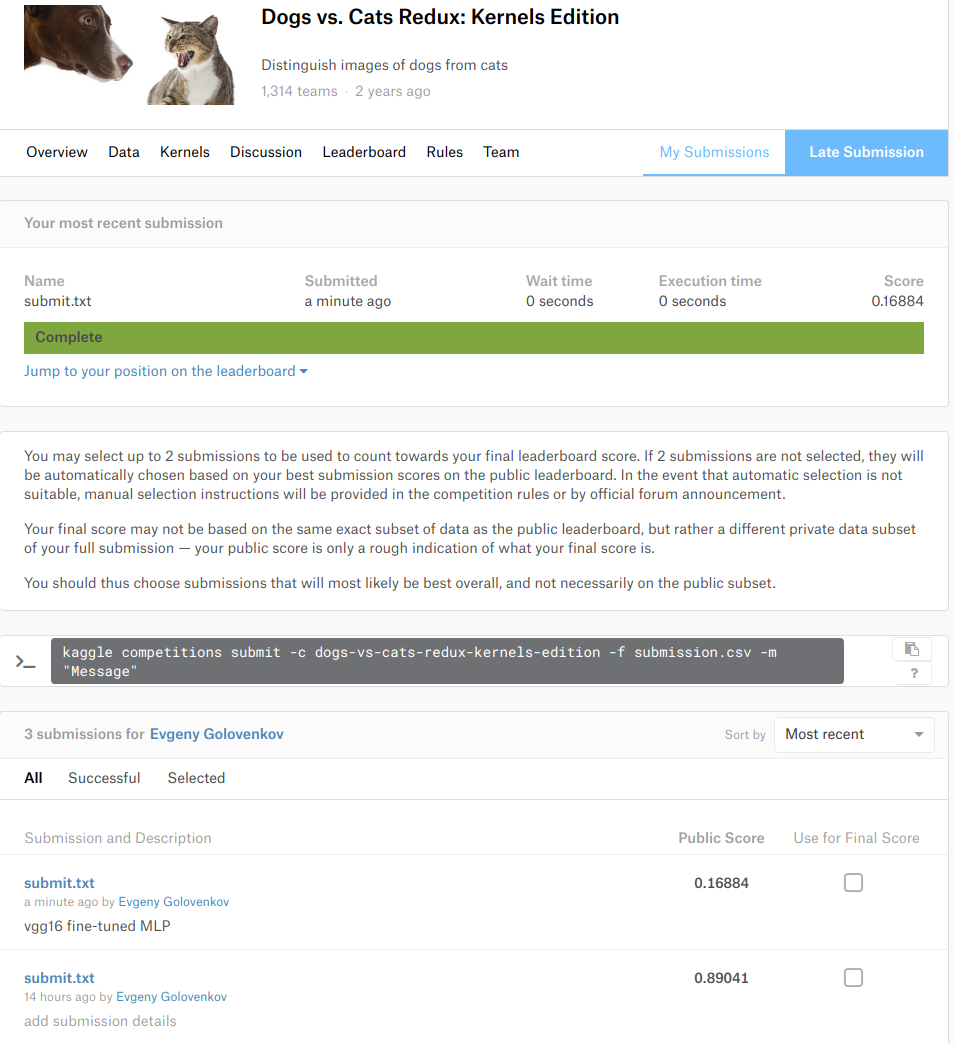